In [82]:
import pickle
from forecast import Forecaster

with open('..\\deep learning\\trained_forecaster.pkl', 'rb') as f:
    forecaster = pickle.load(f)

In [84]:
import pandas as pd

def fetch_observations(filepath, from_date, to_date):
    data = pd.read_csv(filepath)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index(['Date', 'Hour'], inplace=True)
    data = data.loc[(from_date, 6):(to_date, 24)]
    data.reset_index(inplace=True)
    return data

Parker_temperature


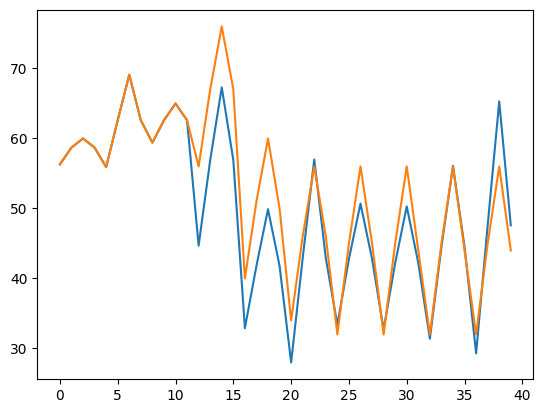

In [96]:
import matplotlib.pyplot as plt

date = '2023-12-24'
days_forward = 7
county = 'Parker'
variable = 'Temperature'

d1 = pd.to_datetime(date)
d2 = d1 - pd.Timedelta(days=1)
d3 = d1 - pd.Timedelta(days=3)
d4 = d1 + pd.Timedelta(days=days_forward-1)

forecaster.generate(date, days_forward)

historical_observations = fetch_observations('..\\preprocessing\\county_variables.csv', str(d3.date()), str(d2.date()))
actual_observations = fetch_observations('..\\preprocessing\\county_variables.csv', str(d1.date()), str(d4.date()))
predicted_observations = fetch_observations('forecast.csv', str(d1.date()), str(d4.date()))

actual_df = pd.concat((historical_observations, actual_observations), ignore_index=True)
predicted_df = pd.concat((historical_observations, predicted_observations), ignore_index=True)

column_name = f'{county}_{variable.lower()}'
print(column_name)

actual_variable = actual_df[column_name].values
predicted_variable = predicted_df[column_name].values

plt.plot(range(len(actual_variable)), actual_variable, predicted_variable)
plt.show()